# 画像メディア工学６回目
## 6. 周波数領域におけるフィルタリング（フーリエ変換）
### ライブラリの読み込み（おまじない）

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

### 6.1 １次元データのフーリエ変換
画像のフーリエ変換（２次元フーリエ変換）の前に，フーリエ変換の簡単な説明として１次元データのフーリエ変換．

### Cos波の合成のフーリエ変換
例では，$y = 1 + 3 \cos(x) + 2 \sin(5 x)$

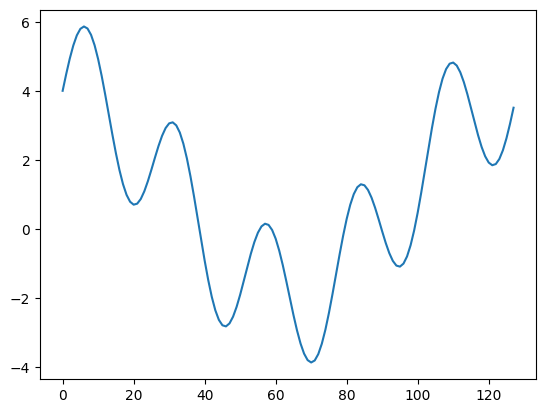

In [ ]:
N = 128   # サンプル数
dx = 2*np.pi/N
x = np.arange(0, 2*np.pi, dx)   # 0～2πまでのN個の配列

w1 = 1    # 1つ目の周波数
w2 = 5    # 2つ目の周波数

a0 = 1    # 直流成分
a1 = 3    # 1つ目の周波数
a2 = 2    # 2つ目の周波数

y = a0 + a1*np.cos(w1*x) + a2*np.sin(w2*x)   # 2つのcos信号の合成

plt.plot(y);

### フーリエ変換（１次元フーリエ変換）
np.fft.fft()関数でできる

In [ ]:
F = np.fft.fft(y)
F = F/(N/2)

### 振幅スペクトルと位相スペクトルの計算・表示

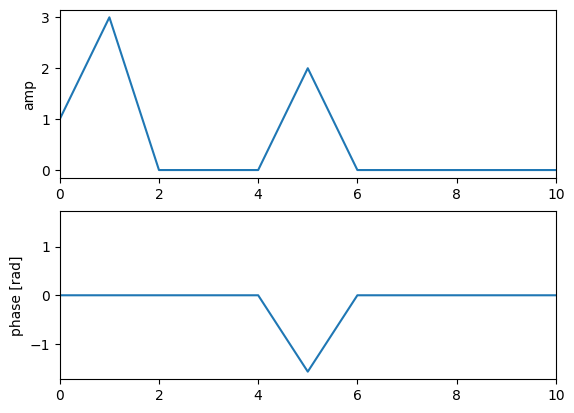

In [ ]:
# 振幅の計算
amp   = np.sqrt(F.real*F.real+F.imag*F.imag)
amp[0] = amp[0]/2

# 位相の計算
phase = np.arctan2(F.imag, F.real)
phase[amp<0.01] = 0 # 振幅スペクトルがほぼ0の周波数は位相を0として描画

# 振幅スペクトルのプロット
plt.subplot(211)
plt.plot(amp)
plt.xlim(0,10) # グラフのx軸の範囲を設定（低周波部分のみ描画）
plt.ylabel("amp")

#位相スペクトルのプロット
plt.subplot(212)
plt.plot(phase)
plt.xlim(0,10)
plt.ylabel("phase [rad]");

### 6.2 画像のフーリエ変換

### 画像の読み込み
変換対象の画像はなんでも良いですが，ここでは以下の画像を利用するためにアップロード．

https://github.com/yamazoe/ImageMediaProcessing/raw/main/img/img03.png

In [ ]:
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img03.png -O img03.png

--2024-11-16 05:31:55--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img03.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113385 (111K) [image/png]
Saving to: ‘img03.png’

img03.png           100%[===================>] 110.73K  --.-KB/s    in 0.03s   

2024-11-16 05:31:55 (3.27 MB/s) - ‘img03.png’ saved [113385/113385]



アップロードした画像の読み込み

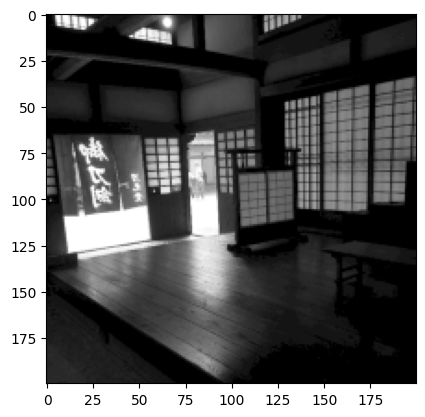

In [ ]:
img = cv2.imread('img03.png', 0);  # モノクロ画像として読み込み
plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)

### 画像のフーリエ変換
`np.fft.fft2()` 関数を用いる

In [ ]:
fimg = np.fft.fft2(img)

### 振幅スペクトル描画の関数
振幅スペクトル描画の前に，振幅スペクトルの計算などの前処理が必要なため，関数として定義しておく（詳細は気にしなくても良いです）

plt_fft_result()関数:
- fimg: np.fft.fft2()の結果
- 出力: 振幅スペクトルのプロット

In [ ]:
def plot_fft_result(fimg):
    fimg[np.abs(fimg)<1] = 1             # 振幅スペクトル計算時のエラー回避
    fimg_shift =  np.fft.fftshift(fimg)  # 直流成分を画像の左上から中心に移動
    mag = 20*np.log(np.abs(fimg_shift))  # 強度スペクトルの計算

    plt.imshow(mag, cmap = 'gray')
    plt.title('Amplitude spectrum')

実行すると，

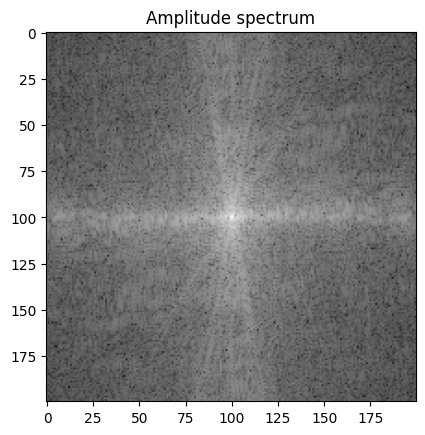

In [ ]:
plot_fft_result(fimg)

### 振幅スペクトルから画像の復元（逆フーリエ変換）
`np.fft.ifft()` 関数を利用する．

In [ ]:
ifft_img = np.fft.ifft2(fimg)

逆フーリエ変換の結果を描画する際には，実部(ifft_img.real)のみを指定する．

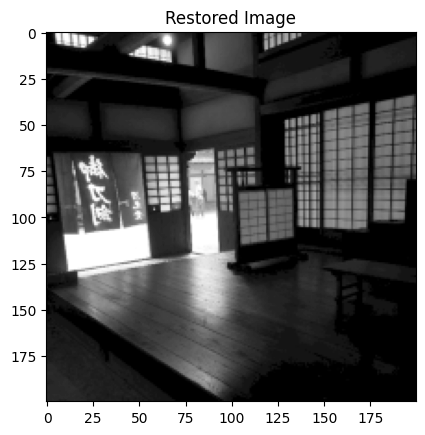

In [ ]:
plt.imshow(ifft_img.real, cmap = 'gray')
plt.title('Restored Image');

### 5.3 周波数領域におけるフィルタリング
上の振幅スペクトル画像に対して処理を行ってから逆フーリエ変換をすることで，周波数領域でのフィルタリングが実現できる．
こちらも前処理などがあるため，関数を定義しておく．（詳細は気にしなくても良いです）

freq_filtering()関数:
- fimg: 振幅スペクトル画像（np.fft.fft2()の出力）
- filter: フィルタ
- 戻り値: フィルタと周波数フィルタリング結果の描画

In [ ]:
def freq_filtering(fimg, filter):
    fimg_shift = np.fft.fftshift(fimg)  # 直流成分を画像の左上から中心へと移動
    fimg_shift = fimg_shift * filter    # スペクトル画像に対してfilterをかける
    ifft_img = np.fft.ifft2(np.fft.ifftshift(fimg_shift)) # 逆フーリエ変換

    fimg_shift[np.abs(fimg_shift)<1] = 1    # log計算時のエラー対策（log0にしない）
    mag = 20*np.log(np.abs(fimg_shift))  # 強度スペクトルの計算

    plt.subplot(121)
    plt.imshow(filter, cmap = 'gray')
    plt.title('Filter')
    plt.subplot(122)
    plt.imshow(mag, cmap = 'gray')
    plt.title('Filtered Spectrum')
    plt.show()

    return ifft_img.real # 実部のみが必要

ローパスフィルタとハイパスフィルタを定義し描画

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
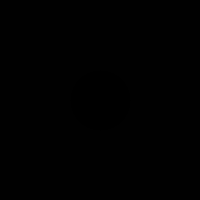

In [ ]:
# フーリエ変換結果の配列サイズ（＝元画像サイズ）と画像中心の座標取得
w, h = fimg.shape
cx, cy = int(h/2), int(w/2)

# ローパスフィルタの定義
low_pass = np.zeros((w,h), dtype=np.uint8) # フーリエ変換結果と同じサイズの配列を作成（中身は全てゼロ）
cv2.circle(low_pass, (cx,cy), 30, 1, -1)  # フィルタ画像に，(cx,cy)を中心とした半径30，明るさ1の円を描く)

# ハイパスフィルタの定義
high_pass = np.ones((w,h), dtype=np.uint8) # フーリエ変換結果と同じサイズの配列を作成（中身は全て１）
cv2.circle(high_pass, (cx,cy), 30, 0, -1)  # フィルタ画像に，(cx,cy)を中心とした半径30，明るさ0の円を描く)

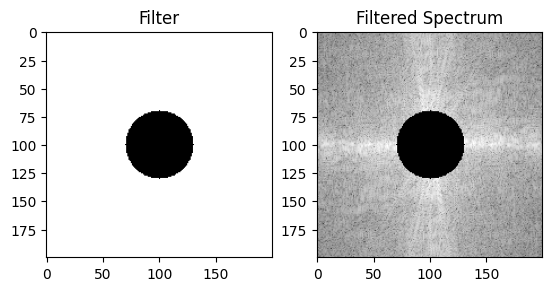

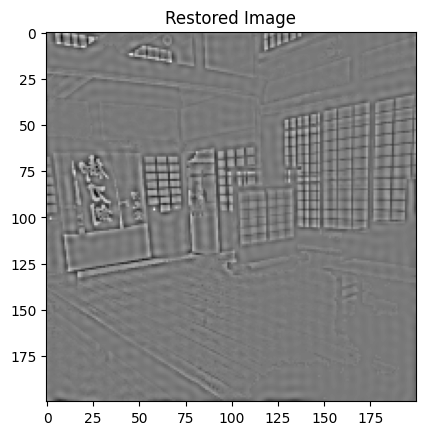

In [ ]:
# フィルタの処理
filtered = freq_filtering(fimg, high_pass)

# 逆フーリエ変換結果の描画
plt.imshow(filtered, cmap = 'gray')
plt.title('Restored Image');

### 課題１（必須）
以下のプログラムを変更し，
1. 縦縞の画像
2. 横縞の画像　　が出力されるようにしてください．

修正が必要な部分は、
- 変数Th（ローパス・ハイパスフィルタの周波数の閾値）の値
- ローパスフィルタ・ハイパスフィルタのどちらを適用するか　　の２カ所です．

実行の前に，課題用のファイル(img04.png)をアップロード．

https://github.com/yamazoe/ImageMediaProcessing/raw/main/img/img04.png

In [ ]:
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img04.png -O img04.png

--2024-11-16 05:32:01--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img04.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10260 (10K) [image/png]
Saving to: ‘img04.png’

img04.png           100%[===================>]  10.02K  --.-KB/s    in 0.001s  

2024-11-16 05:32:02 (17.3 MB/s) - ‘img04.png’ saved [10260/10260]



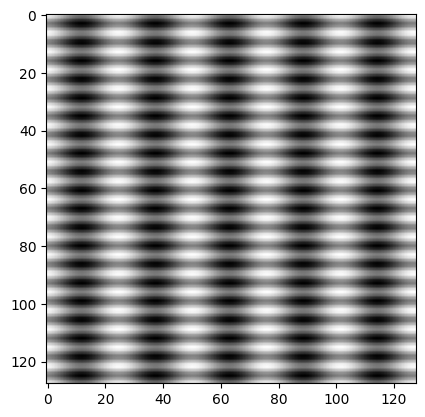

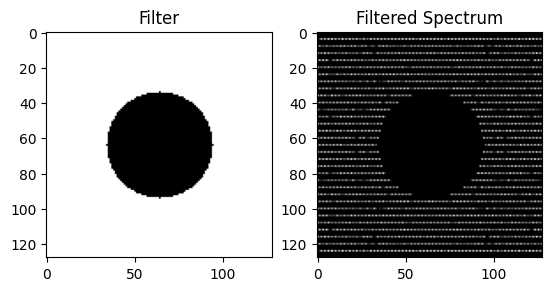

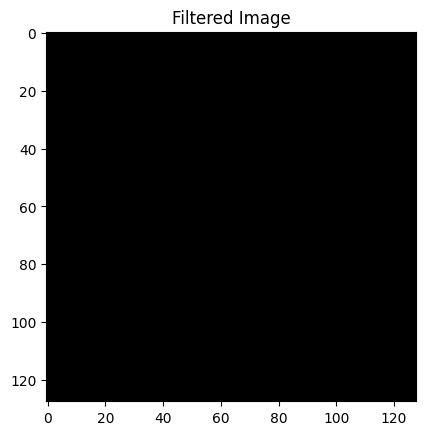

In [ ]:
img2 = cv2.imread('img04.png', 0);  # モノクロ画像として読み込み
plt.imshow(img2, cmap='gray', vmin = 0, vmax = 255)
plt.show() # 画像表示

fimg2 = np.fft.fft2(img2)

# ローパス・ハイパスフィルタの閾値（この値を変化させてください）
Th = 30

# ローパスフィルタ・ハイパスフィルタの定義
w2, h2 = fimg2.shape
cx2, cy2 = int(h2/2), int(w2/2)

low_pass2 = np.zeros((w2,h2), dtype=np.uint8)
cv2.circle(low_pass2, (cx2,cy2), Th, 1, -1)

high_pass2 = np.ones((w2,h2), dtype=np.uint8)
cv2.circle(high_pass2, (cx2,cy2), Th, 0, -1)

# フィルタの処理 (ローパス・ハイパスのいずれかを適用するようにコメントを外してください)
#filtered2 = freq_filtering(fimg2, low_pass2) # ローパスフィルタを適用
filtered2 = freq_filtering(fimg2, high_pass2) # ハイパスフィルタを適用

# 逆フーリエ変換結果の描画
plt.imshow(filtered2, cmap = 'gray', vmin=0, vmax=255)
plt.title('Filtered Image');

### 課題２
以下の画像はどういった処理をした画像と思うかを回答してください．

<img src="https://github.com/yamazoe/ImageMediaProcessing/blob/main/img/test.png?raw=true" width=25%>